## using statement

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

## Constant

In [20]:
RANDOM_STATE=42

## Read data from file

In [21]:
def read_data(path_fake,path_true):
    df_fake=pd.read_csv(path_fake)
    df_true=pd.read_csv(path_true)
    df_fake["label"]="fake"
    df_true["label"]="true"
    df_fake["target"]=0
    df_true["target"]=1

    df=pd.concat([df_fake,df_true],ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [22]:
df=read_data("Fake.csv","True.csv")

## Clean data

In [23]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                              # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)               # remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra whitespace
    return text

In [24]:
def avg_word_length_long_words(text):
    words = text.split()
    long_words = [w for w in words if len(w) >= 4]
    if not long_words:  # avoid division by zero
        return 0
    return sum(len(w) for w in long_words) / len(long_words)

In [25]:
def avg_sentences_length(text):
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if not sentences:
        return 0
    sentences_length = [len(s.split()) for s in sentences]  # length in words
    return np.mean(sentences_length)


In [26]:
def clean_data(df):
    df['title'] = df['title'].apply(clean_text)
    df['text'] = df['text'].apply(clean_text)

    df["length_text"]=df["text"].apply(len)
    df["length_title"]=df["title"].apply(len)

    df['text_title_length_relation']=df['length_text']/df['length_title']
    #df=df.drop(columns=["subject"])
    df['avg_len_4plus'] = df['text'].apply(avg_word_length_long_words)
    df['avg_len_sentences'] = df['text'].apply(avg_sentences_length)
    df=df.drop(columns=['title','text','subject','date','label'])
    return df

In [27]:
clean_df=clean_data(df)
clean_df.head()
clean_df.describe()


,target,length_text,length_title,text_title_length_relation,avg_len_4plus,avg_len_sentences
count,44898.000000,44898.000000,44898.000000,44889.000000,44898.000000,44898.000000
mean,0.477015,2375.242505,76.940421,33.342860,6.376942,399.586017
std,0.499477,2091.179825,24.148706,34.233059,0.911967,346.855103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1185.000000,61.000000,14.795699,6.247373,200.000000
50%,0.000000,2106.000000,71.000000,27.756757,6.469697,358.000000
75%,1.000000,2988.000000,87.000000,41.838710,6.689792,506.000000
max,1.000000,50087.000000,270.000000,1742.318182,21.570881,8044.000000


In [33]:
clean_df.head()

,target,length_text,length_title,text_title_length_relation,avg_len_4plus,avg_len_sentences
0,0,1002,83,12.072289,6.533981,170.0
1,1,4668,55,84.872727,6.597959,767.0
2,1,1775,62,28.629032,6.315789,303.0
3,0,1168,85,13.741176,6.983471,180.0
4,1,3016,55,54.836364,6.540984,518.0


## scatter the text and title length

In [37]:
def scatter_title_text_lenght(df):
    df_0 = df[df['target'] == 0]
    plt.scatter(df_0['length_text'], df_0['length_title'], color='red', label='Target 0')

    # Plot points where target == 1 (green)
    df_1 = df[df['target'] == 1]
    plt.scatter(df_1['length_text'], df_1['length_title'], color='green', label='Target 1')

    # Add labels and legend
    plt.xlabel('Length of Text')
    plt.ylabel('Length of Title')
    plt.title('Text vs Title Length by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_4plus'], df_0['text_title_length_relation'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_4plus'], df_1['text_title_length_relation'], color='green', label='Target 1')
    plt.xlabel('avg_len_4plus')
    plt.ylabel('text_title_length_relation')
    plt.title('text_title_length_relation vs avg_len_4plus  by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_4plus'], df_0['length_text'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_4plus'], df_1['length_text'], color='green', label='Target 1')
    plt.xlabel('avg_len_4plus')
    plt.ylabel('length_text')
    plt.title('length_text vs avg_len_4plus  by Target')
    plt.legend()

    # Show plot
    plt.show()

    
    plt.scatter(df_0['avg_len_4plus'], df_0['length_title'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_4plus'], df_1['length_title'], color='green', label='Target 1')
    plt.xlabel('avg_len_4plus')
    plt.ylabel('length_title')
    plt.title('length_title vs avg_len_4plus  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['avg_len_sentences'], df_0['text_title_length_relation'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_sentences'], df_1['text_title_length_relation'], color='green', label='Target 1')
    plt.xlabel('avg_len_sentences')
    plt.ylabel('text_title_length_relation')
    plt.title('text_title_length_relation vs avg_len_sentences by Target')
    plt.legend()

    # Show plot
    plt.show()
    
    

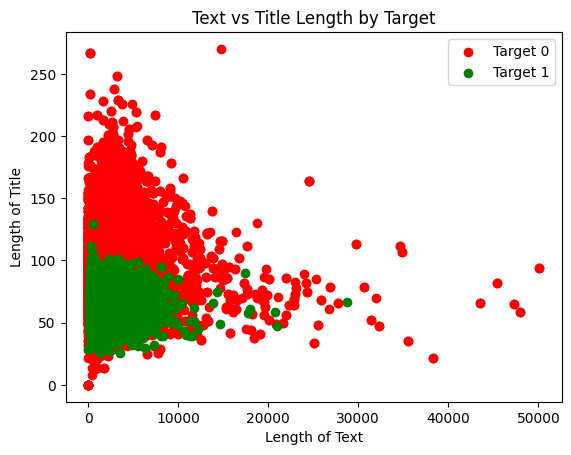

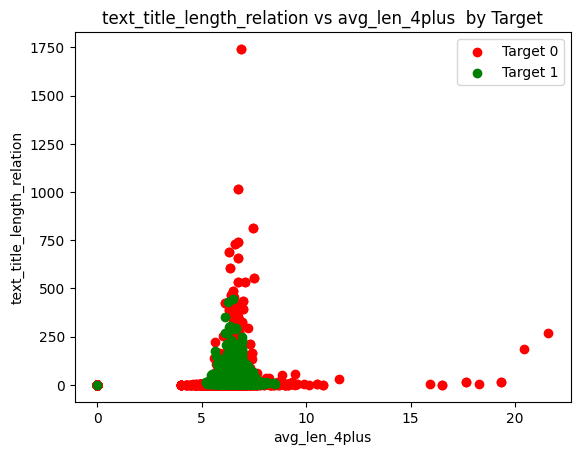

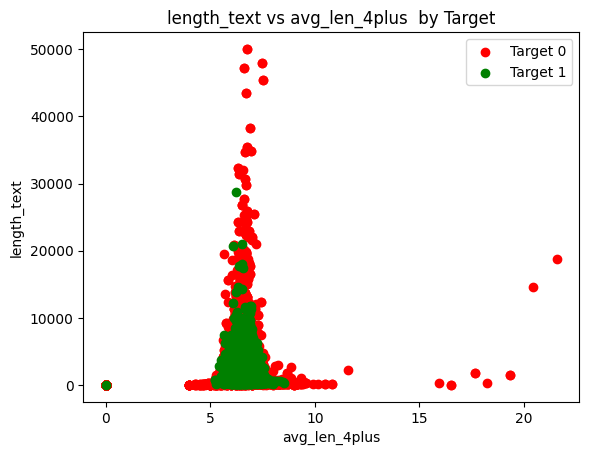

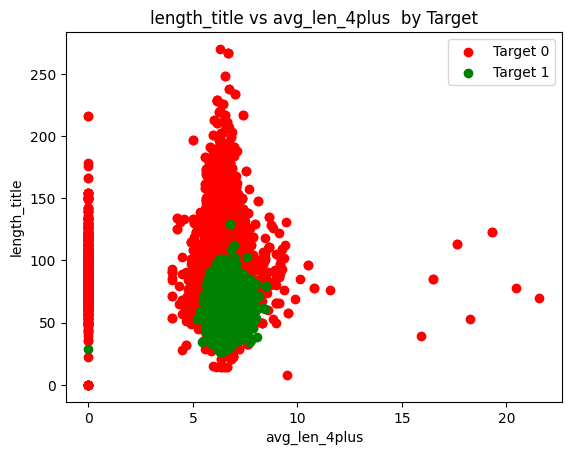

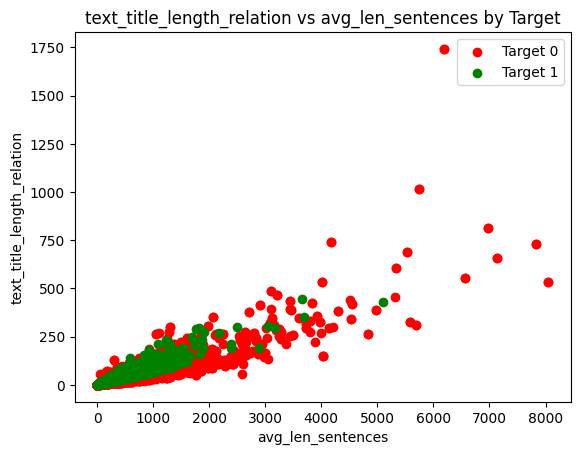

In [38]:
scatter_title_text_lenght(clean_df)

## seperate the X and Y

In [31]:
x_df=clean_df.drop(columns=['target'])
y_df=clean_df["target"]

## split the train test

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x_df,y_df,test_size=0.2,random_state=RANDOM_STATE)